In [1]:
#pip install kagglehub

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")

print("Path to dataset files:", path)
path = r"C:\Users\sagro\.cache\kagglehub\datasets\adarshsng\lending-club-loan-data-csv\versions\1\loan.csv"



df = pd.read_csv(path, low_memory=False)


# Printing usual info and seeing what the target veriable looks like 
print(df.info())
print(df['loan_status'].value_counts())
print(df['loan_status'].unique())

Path to dataset files: C:\Users\sagro\.cache\kagglehub\datasets\adarshsng\lending-club-loan-data-csv\versions\1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB
None
loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64
['Current' 'Fully Paid' 'Late (31-120 days)' 'In Grace Period'
 'Charged Off' 'Late (16-3

In [5]:
#df.head()

In [6]:
# Step 2: Create binary target variable
# Why exclude ongoing loans?
# - "Current", "In Grace Period", and "Late" loans have uncertain outcomes
# - Including them would introduce label leakage: we don't know if they'll ultimately be paid or default
# - Training on uncertain outcomes would bias the model and inflate accuracy metrics
# - In production, we need to predict outcomes for NEW loans, not monitor existing ones
#
# Why binary classification?
# - Simplifies the problem: will the borrower repay (0) or default (1)?
# - Clear business objective: identify high-risk loans before approval
# - Easier to interpret and set decision thresholds for loan approval

# Only keep loans with definitive outcomes (exclude ongoing loans)
good_loan_statuses = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
bad_loan_statuses = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']

# Filter to only include loans with definitive outcomes
df_resolved = df[df['loan_status'].isin(good_loan_statuses + bad_loan_statuses)].copy()

# Create binary target: 0 = good (fully paid), 1 = bad (defaulted/charged off)
df_resolved['loan_status_binary'] = df_resolved['loan_status'].apply(
    lambda x: 0 if x in good_loan_statuses else 1
)

print(f"\nOriginal dataset size: {len(df)}")
print(f"Filtered dataset size (resolved loans only): {len(df_resolved)}")
print(f"\nExcluded ongoing loans: {len(df) - len(df_resolved)}")
print(f"\nFinal binary target distribution:")
print(df_resolved['loan_status_binary'].value_counts())
print(f"\nClass imbalance ratio (bad/good): {df_resolved['loan_status_binary'].sum() / (len(df_resolved) - df_resolved['loan_status_binary'].sum()):.3f}")


"""
What You're PredictingPredicting: Will a borrower DEFAULT on their loan?
0 = Fully Paid (borrower paid back the loan)
1 = Charged Off/Default (borrower stopped paying, lender lost money)
Why Would We Do This?1. Investor Perspective (Most Common Use Case)
On peer-to-peer lending platforms like LendingClub:

Investors browse available loans
They decide which loans to fund based on risk/return
Your model helps: "Should I invest in this loan or will the borrower default?"
Business value: Avoid bad loans, maximize returns2. Lender Perspective (Credit Risk Assessment)
Banks/lenders want to:

Decide who gets approved
Set appropriate interest rates
Estimate expected losses
Business value: Reduce default rates, optimize pricing
"""





Original dataset size: 2260668
Filtered dataset size (resolved loans only): 1306387

Excluded ongoing loans: 954281

Final binary target distribution:
loan_status_binary
0    1043940
1     262447
Name: count, dtype: int64

Class imbalance ratio (bad/good): 0.251


'\nWhat You\'re PredictingPredicting: Will a borrower DEFAULT on their loan?\n0 = Fully Paid (borrower paid back the loan)\n1 = Charged Off/Default (borrower stopped paying, lender lost money)\nWhy Would We Do This?1. Investor Perspective (Most Common Use Case)\nOn peer-to-peer lending platforms like LendingClub:\n\nInvestors browse available loans\nThey decide which loans to fund based on risk/return\nYour model helps: "Should I invest in this loan or will the borrower default?"\nBusiness value: Avoid bad loans, maximize returns2. Lender Perspective (Credit Risk Assessment)\nBanks/lenders want to:\n\nDecide who gets approved\nSet appropriate interest rates\nEstimate expected losses\nBusiness value: Reduce default rates, optimize pricing\n'

In [7]:
# Step 3: We remove the columns with > 30% missing data and where the missing data is not informative
# High missing data can introduce bias and reduce model performance
# Imputing >30% missing values would create more synthetic than real data
print(f"\n{'='*60}")
print("Step 3: Removing columns with >30% missing data")
print(f"{'='*60}")

# Calculate missing percentage for each column
missing_pct = (df_resolved.isnull().sum() / len(df_resolved)) * 100
print(f"\nOriginal number of columns: {len(df_resolved.columns)}")

# Identify columns to drop
cols_to_study_drop = missing_pct[missing_pct > 30].sort_values(ascending=False)
print(f"\nColumns with >30% missing data ({len(cols_to_study_drop)} total):")

for col, pct in cols_to_study_drop.items():
    print(f"  - {col}: {pct:.1f}% missing")

"""
Not About Current Loan
Revolving accounts (credit cards, not installment loans):

open_rv_12m, open_rv_24m - revolving accounts, not installment ✓
max_bal_bc - bankcard balances ✓
mths_since_recent_revol_delinq - revolving accounts ✓

Past history:

mths_since_last_record - public records (bankruptcies, liens) ✓

Inquiries:

inq_last_12m, inq_fi - credit inquiries ✓
"""

# Here we decided to keep those which could be informative even with a lot of missing data.
cols_to_drop = cols_to_study_drop.drop(labels=[
    'open_rv_12m',
    'open_rv_24m',
    'max_bal_bc',
    'mths_since_recent_revol_delinq',
    'mths_since_last_record',
    'inq_last_12m',
    'inq_fi',
])

# Drops the columns
df_cleaned = df_resolved.drop(columns=cols_to_drop.index)
print(f"\nRemaining columns: {len(df_cleaned.columns)}")
print(f"Columns removed: {len(cols_to_drop)}")
print(list(df_cleaned.columns))


Step 3: Removing columns with >30% missing data

Original number of columns: 146

Columns with >30% missing data (58 total):
  - id: 100.0% missing
  - member_id: 100.0% missing
  - url: 100.0% missing
  - next_pymnt_d: 99.8% missing
  - orig_projected_additional_accrued_interest: 99.7% missing
  - hardship_end_date: 99.6% missing
  - hardship_reason: 99.6% missing
  - hardship_status: 99.6% missing
  - hardship_type: 99.6% missing
  - hardship_start_date: 99.6% missing
  - deferral_term: 99.6% missing
  - hardship_last_payment_amount: 99.6% missing
  - hardship_payoff_balance_amount: 99.6% missing
  - hardship_amount: 99.6% missing
  - payment_plan_start_date: 99.6% missing
  - hardship_length: 99.6% missing
  - hardship_dpd: 99.6% missing
  - hardship_loan_status: 99.6% missing
  - sec_app_mths_since_last_major_derog: 99.5% missing
  - sec_app_revol_util: 98.8% missing
  - revol_bal_joint: 98.7% missing
  - sec_app_mort_acc: 98.7% missing
  - sec_app_num_rev_accts: 98.7% missing
  -

In [8]:
### Removing data leakage columns ###

print(f"\n{'='*60}")
print("Step 4: Removing data leakage columns")
print(f"{'='*60}")

# Payment & Recovery Information (Known Only After Loan Performance)
payment_recovery_cols = [
    'out_prncp',              # Outstanding principal remaining - only known after loan has been active
    'out_prncp_inv',          # Outstanding principal for investors - only known after loan has been active
    'total_pymnt',            # Total payments received to date - directly reflects loan performance
    'total_pymnt_inv',        # Payments received by investors - directly reflects loan performance
    'total_rec_prncp',        # Principal received to date - directly reflects loan performance
    'total_rec_int',          # Interest received to date - directly reflects loan performance
    'total_rec_late_fee',     # Late fees received - indicates payment issues, known only after loan is active
    'recoveries',             # Post charge-off recovery - only exists for defaulted loans
    'collection_recovery_fee',# Collection fee after charge-off - only exists for defaulted loans
    'last_pymnt_d',           # Date of last payment - only known after payments begin
    'last_pymnt_amnt',        # Amount of last payment - only known after payments begin
]

# Hardship Plan Information (Known Only When Borrower Struggles)
hardship_cols = [
    'hardship_flag',                              # Indicates hardship plan - only set when borrower has difficulties
    'hardship_type',                              # Type of hardship - only known when borrower enters hardship
    'hardship_reason',                            # Reason for hardship - only known when borrower enters hardship
    'hardship_status',                            # Hardship status - only known during/after hardship
    'deferral_term',                              # Deferral terms - only set during hardship
    'hardship_amount',                            # Hardship amount - only known during hardship
    'hardship_start_date',                        # When hardship started - future information
    'hardship_end_date',                          # When hardship ended - future information
    'payment_plan_start_date',                    # Payment plan start - future information
    'hardship_length',                            # Length of hardship - only known after/during hardship
    'hardship_dpd',                               # Days past due during hardship - performance information
    'hardship_loan_status',                       # Loan status during hardship - performance information
    'orig_projected_additional_accrued_interest', # Projected interest during hardship - future information
    'hardship_payoff_balance_amount',             # Payoff balance during hardship - future information
    'hardship_last_payment_amount',               # Last payment during hardship - future information
]

# Debt Settlement Information (Known Only for Defaulted Loans)
settlement_cols = [
    'debt_settlement_flag',             # Flags settlement activity - only relevant for charged-off loans
    'debt_settlement_flag_date',        # Date settlement flagged - only known after default
    'settlement_status',                # Settlement status - only known after default
    'settlement_date',                  # Date of settlement - only known after default
    'settlement_amount',                # Settlement amount - only known after default
    'settlement_percentage',            # Settlement as % of balance - only known after default
    'settlement_term',                  # Settlement terms - only known after default
]

# Payment Plan (Known Only When Borrower Has Payment Difficulties)
payment_plan_cols = [
    'pymnt_plan',  # Payment plan in place - typically set due to payment difficulties
]

# Original Target Variable
target_cols = [
    'loan_status',  # Original multi-class target - directly reveals outcome
]

# Potentially Problematic (May Be Updated During Loan Lifecycle)
potentially_problematic_cols = [
    'last_credit_pull_d',  # May be updated during loan lifecycle based on performance
]

possible_leakage = [
    'funded_amnt',              # Amount actually funded (post-approval decision)
    'funded_amnt_inv',          # Amount funded by investors (post-approval)
    'initial_list_status',      # Listing status on platform (post-approval)
    'disbursement_method',      # How loan was disbursed (post-approval)
]

# Combine all leakage columns
all_leakage_cols = (possible_leakage + payment_recovery_cols + hardship_cols + settlement_cols +
                    payment_plan_cols + target_cols + potentially_problematic_cols)

# Only drop columns that actually exist in the dataframe
leakage_cols_to_drop = [col for col in all_leakage_cols if col in df_cleaned.columns]
leakage_cols_missing = [col for col in all_leakage_cols if col not in df_cleaned.columns]

print(f"\nData leakage columns found and removed: {len(leakage_cols_to_drop)}")
print(f"Data leakage columns not in dataset: {len(leakage_cols_missing)}")

# Drop the leakage columns
df_no_leakage = df_cleaned.drop(columns=leakage_cols_to_drop)

print(f"\nColumns before leakage removal: {len(df_cleaned.columns)}")
print(f"Columns after leakage removal: {len(df_no_leakage.columns)}")
print(f"\nRemaining columns for modeling:")
print(list(df_no_leakage.columns))





Step 4: Removing data leakage columns

Data leakage columns found and removed: 20
Data leakage columns not in dataset: 20

Columns before leakage removal: 95
Columns after leakage removal: 75

Remaining columns for modeling:
['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim', 'inq_fi', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',

In [9]:
# Step 5: Inspect categorical variables for inconsistencies
# Before encoding, we need to ensure categorical values are properly standardized
# (e.g., "Class1" and "Class 1" should be the same category)
print(f"\n{'='*60}")
print("Step 5: Inspecting categorical variables")
print(f"{'='*60}")


# Identify categorical columns (object and category dtypes)
categorical_cols = df_no_leakage.select_dtypes(include=['object', 'category']).columns.tolist()




# loan_status_binary is already transformed into binary so does not exist in the categorical_cols
# categorical_cols.remove('loan_status_binary')

# we will see later on that there are no malformatted dates but there are a lot of them so best remove for the
# in this inspection
"""
the following lines were added later on because there are way too many values
"""
categorical_cols.remove('zip_code')
categorical_cols.remove('issue_d')
categorical_cols.remove('earliest_cr_line')
"""
Note: earliest_cr line's and issue_d encoding is done later on, because I need the for the join and feature engineering: the format is :
'Dec-1999' [str]: 6698 (0.51%)
  'Mar-2004' [str]: 6642 (0.51%)
  'May-2002' [str]: 6559 (0.50%)
"""

# these columns have way to much unformatted/ useful data, so removed from the inpection now and eventually removed in the 
# outlier removal step"
categorical_cols.remove('emp_title')
categorical_cols.remove('title')


print(f"\nFound {len(categorical_cols)} categorical columns to inspect\n")

# Inspect each categorical column
for col in categorical_cols:
    print(f"\n{'='*80}")
    print(f"Column: {col}")
    print(f"{'='*80}")

    # Get value counts
    value_counts = df_no_leakage[col].value_counts(dropna=False)

    print(f"Total unique values: {len(value_counts)}")
    print(f"Missing values: {df_no_leakage[col].isnull().sum()}")
    print(f"\nValue distribution:")

    # Show all unique values with their counts
    for value, count in value_counts.items():
        # Show the value with its type to help identify inconsistencies
        print(f"  '{value}' [{type(value).__name__}]: {count} ({count/len(df_no_leakage)*100:.2f}%)")

    print()

print(f"\n{'='*80}")
print("INSPECTION COMPLETE")
print(f"{'='*80}")
print("\nReview the output above and identify any values that should be grouped together.")
print("For example: 'Class1' and 'Class 1', or different capitalizations, etc.")


"""
# Note on verification_status:
# After inspection, verification_status has 3 categories: 'Source Verified', 'Verified', 'Not Verified'
# We considered grouping 'Source Verified' and 'Verified' into a single 'Verified' category
# However, after research, we decided to keep all 3 categories separate because:
# - 'Source Verified' indicates that the income source was verified (more rigorous)
# - 'Verified' indicates income was verified but not the source (less rigorous)
# - This distinction may have predictive value for default risk
# - The model can learn these nuances if they exist in the data
"""

"""
home_ownership : 
Total unique values: 6
Missing values: 0

Value distribution:
  'MORTGAGE' [str]: 646765 (49.51%)
  'RENT' [str]: 519084 (39.73%)
  'OWN' [str]: 140036 (10.72%)
  'ANY' [str]: 267 (0.02%)
  'OTHER' [str]: 182 (0.01%)   -> group with 'ANY'? No idea what it means
  'NONE' [str]: 53 (0.00%)
"""

# all the other categorical functions other than verification_status seemed fine after inspection
# except emp_length, emp_title and title which we must remove later on due to too many unique values/ unformatted data
df_no_leakage = df_no_leakage.drop(columns=["emp_title", "title"])






Step 5: Inspecting categorical variables

Found 9 categorical columns to inspect


Column: term
Total unique values: 2
Missing values: 0

Value distribution:
  ' 36 months' [str]: 991212 (75.87%)
  ' 60 months' [str]: 315175 (24.13%)


Column: grade
Total unique values: 7
Missing values: 0

Value distribution:
  'B' [str]: 380512 (29.13%)
  'C' [str]: 370566 (28.37%)
  'A' [str]: 226343 (17.33%)
  'D' [str]: 195979 (15.00%)
  'E' [str]: 92110 (7.05%)
  'F' [str]: 31732 (2.43%)
  'G' [str]: 9145 (0.70%)


Column: sub_grade
Total unique values: 35
Missing values: 0

Value distribution:
  'C1' [str]: 82938 (6.35%)
  'B4' [str]: 80683 (6.18%)
  'B5' [str]: 79680 (6.10%)
  'B3' [str]: 79498 (6.09%)
  'C2' [str]: 76997 (5.89%)
  'C3' [str]: 72864 (5.58%)
  'C4' [str]: 72243 (5.53%)
  'B2' [str]: 71746 (5.49%)
  'B1' [str]: 68905 (5.27%)
  'C5' [str]: 65524 (5.02%)
  'A5' [str]: 62119 (4.76%)
  'A4' [str]: 50538 (3.87%)
  'D1' [str]: 50072 (3.83%)
  'D2' [str]: 43616 (3.34%)
  'A1' [str]: 41

In [10]:
#### Step 6: Encoding categorical variables needed to continue taking out suspicious data leakage####

print(f"\n{'='*60}")
print("Step 6: Encoding categorical variables")
print(f"{'='*60}")

# Identifying remaining categorical columns (after dropping emp_title and title)
categorical_cols_final = df_no_leakage.select_dtypes(include=['object', 'category']).columns.tolist()

"""
I need to keep these ones intact for now so I cannot do categorical encoding
"""
categorical_cols_final.remove('zip_code')
categorical_cols_final.remove('issue_d')
categorical_cols_final.remove('earliest_cr_line')
categorical_cols_final.remove('addr_state') # for later joining with state level data


print(f"\nCategorical columns to encode: {len(categorical_cols_final)}")
print(categorical_cols_final)

# Create a copy for encoding
df_encoded = df_no_leakage.copy()

# Handle emp_length separately as it's ordinal (has natural ordering)
# Format: "< 1 year", "1 year", "2 years", ..., "10+ years"
if 'emp_length' in categorical_cols_final:
    print("\nEncoding emp_length (ordinal)...")

    # Define the ordinal mapping
    emp_length_map = {
        '< 1 year': 0,
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10
    }

    # Map values, preserving NaN
    df_encoded['emp_length'] = df_no_leakage['emp_length'].map(emp_length_map)
    print(f"  emp_length encoded: {df_encoded['emp_length'].nunique()} unique values")
    print(f"  Missing values preserved: {df_encoded['emp_length'].isnull().sum()}")




# Encode remaining categorical columns using Label Encoding
# Label encoding works well with XGBoost and preserves missing values
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in categorical_cols_final:
    print(f"\nEncoding {col}...")

    # Create label encoder
    le = LabelEncoder()

    # Get non-null values
    non_null_mask = df_no_leakage[col].notna()

    # Fit and transform only non-null values
    if non_null_mask.sum() > 0:
        df_encoded.loc[non_null_mask, col] = le.fit_transform(df_no_leakage.loc[non_null_mask, col])
        label_encoders[col] = le

        print(f"  Unique values: {len(le.classes_)}")
        print(f"  Missing values preserved: {df_encoded[col].isnull().sum()}")
    else:
        print(f"  Column has no non-null values, skipping encoding")

# Convert encoded columns to appropriate numeric type
for col in categorical_cols_final:
    if col in df_encoded.columns:
        # Use nullable integer type to preserve NaN values
        df_encoded[col] = df_encoded[col].astype('Int64')


print(f"\n{'='*60}")
print("Encoding complete!")
print(f"{'='*60}")
print(f"\nDataFrame shape: {df_encoded.shape}")
print(f"Encoded categorical columns: {len(categorical_cols_final) + (1 if 'emp_length' in df_no_leakage.columns else 0)}")

# Verify no information was lost
print(f"\nVerification:")
print(f"  Rows before encoding: {len(df_no_leakage)}")
print(f"  Rows after encoding: {len(df_encoded)}")
print(f"  Total missing values before: {df_no_leakage.isnull().sum().sum()}")
print(f"  Total missing values after: {df_encoded.isnull().sum().sum()}")

df_no_leakage = df_encoded.copy()








Step 6: Encoding categorical variables

Categorical columns to encode: 8
['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'application_type']

Encoding emp_length (ordinal)...
  emp_length encoded: 11 unique values
  Missing values preserved: 75491

Encoding term...
  Unique values: 2
  Missing values preserved: 0

Encoding grade...
  Unique values: 7
  Missing values preserved: 0

Encoding sub_grade...
  Unique values: 35
  Missing values preserved: 0

Encoding emp_length...
  Unique values: 11
  Missing values preserved: 75491

Encoding home_ownership...
  Unique values: 6
  Missing values preserved: 0

Encoding verification_status...
  Unique values: 3
  Missing values preserved: 0

Encoding purpose...
  Unique values: 14
  Missing values preserved: 0

Encoding application_type...
  Unique values: 2
  Missing values preserved: 0

Encoding complete!

DataFrame shape: (1306387, 73)
Encoded categorical columns: 9

Verification:
  Rows be

In [11]:
#pip install xgboost


In [12]:
### Step 7: taking care of hidden data leakage/ suspiciously predictive features
print("step 7: checking for hidden data leakage")
print(df_no_leakage.info())
print(list(df_no_leakage.columns))
# Calculate missing percentage for each column
missing_pct_2 = (df_no_leakage.isnull().sum() / len(df_no_leakage)) * 100
print(f"\nnumber of columns: {len(df_no_leakage.columns)}")
# Identifications of still missing columns
for col, pct in missing_pct_2.items():
    if abs(pct) > 1e-12:
        print(f"  - {col}: {pct}% missing")


"""
GBoost Handles Missing Values
XGBoost doesn't drop or ignore rows with NaNs. Instead, during training, it:

Learns the optimal direction to send missing values at each split (left or right)
Treats missingness as information - it figures out whether missing values should go left or right in the tree to minimize loss
Uses all available data from every row
"""
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score

# Split data
X = df_no_leakage.drop(columns=['loan_status_binary', 'zip_code', 'addr_state','issue_d', 'earliest_cr_line'])
y = df_no_leakage['loan_status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train XGBoost
model = xgb.XGBClassifier(random_state=0)
model.fit(X_train, y_train)

# Check feature importance
importance = model.get_booster().get_score(importance_type='gain')
total_gain = sum(importance.values())
importance_pct = {k: (v/total_gain)*100 for k, v in importance.items()}
sorted_importance = sorted(importance_pct.items(), key=lambda x: x[1], reverse=True)

print("CHECKING DATA LEAKAGE")
for feat, pct in sorted_importance:
    print(f"  {feat}: {pct:.1f}%")
    if pct > 20:
        print(f"  Check")

# Cross-validation -> if too big probably means data leakage 
train_acc = model.score(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"\nTrain accuracy: {train_acc:.3f}")
print(f"CV accuracy: {cv_scores.mean():.3f}")
print(f"Gap: {train_acc - cv_scores.mean():.3f}")

print(train_acc)
print(train_acc - cv_scores.mean())



"""
Note sub_grade contains 33% of the information
Note -> there are no REALLY suspicious features, the grades are provided by LC and are based also on more private data 
but they are calculated the moment a loan is approved so they are not leakage
"""

step 7: checking for hidden data leakage
<class 'pandas.core.frame.DataFrame'>
Index: 1306387 entries, 100 to 2260664
Data columns (total 73 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   loan_amnt                       1306387 non-null  int64  
 1   term                            1306387 non-null  Int64  
 2   int_rate                        1306387 non-null  float64
 3   installment                     1306387 non-null  float64
 4   grade                           1306387 non-null  Int64  
 5   sub_grade                       1306387 non-null  Int64  
 6   emp_length                      1230896 non-null  Int64  
 7   home_ownership                  1306387 non-null  Int64  
 8   annual_inc                      1306383 non-null  float64
 9   verification_status             1306387 non-null  Int64  
 10  issue_d                         1306387 non-null  object 
 11  purpose                  

'\nNote sub_grade contains 33% of the information\nNote -> there are no REALLY suspicious features, the grades are provided by LC and are based also on more private data \nbut they are calculated the moment a loan is approved so they are not leakage\n'

Step 8
True


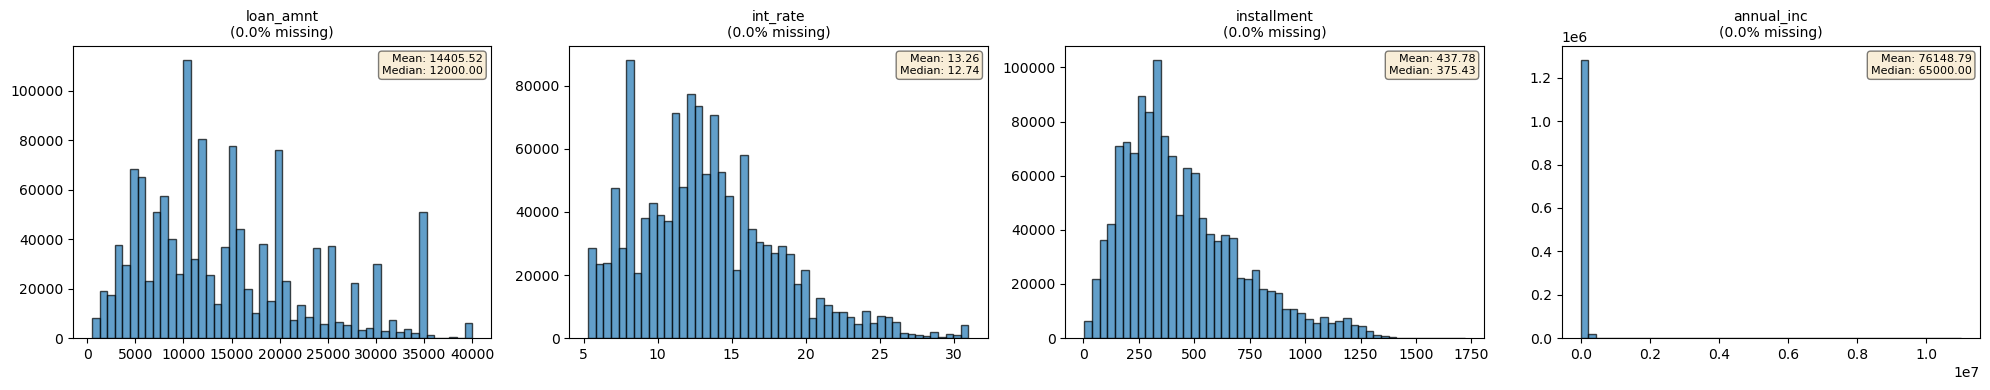

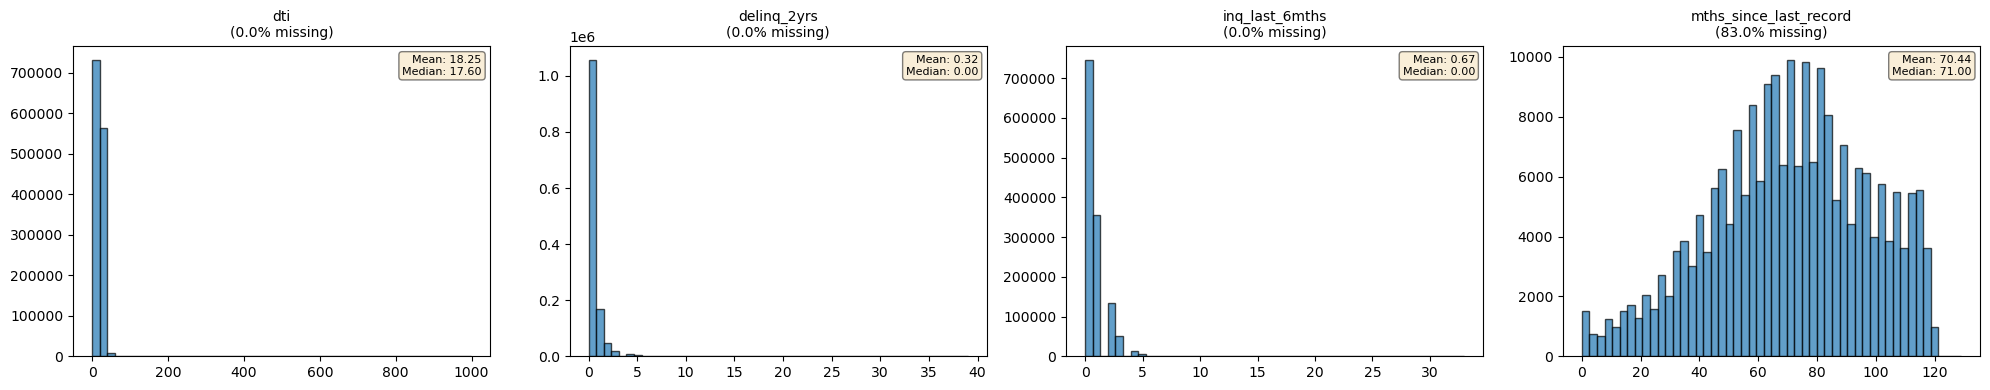

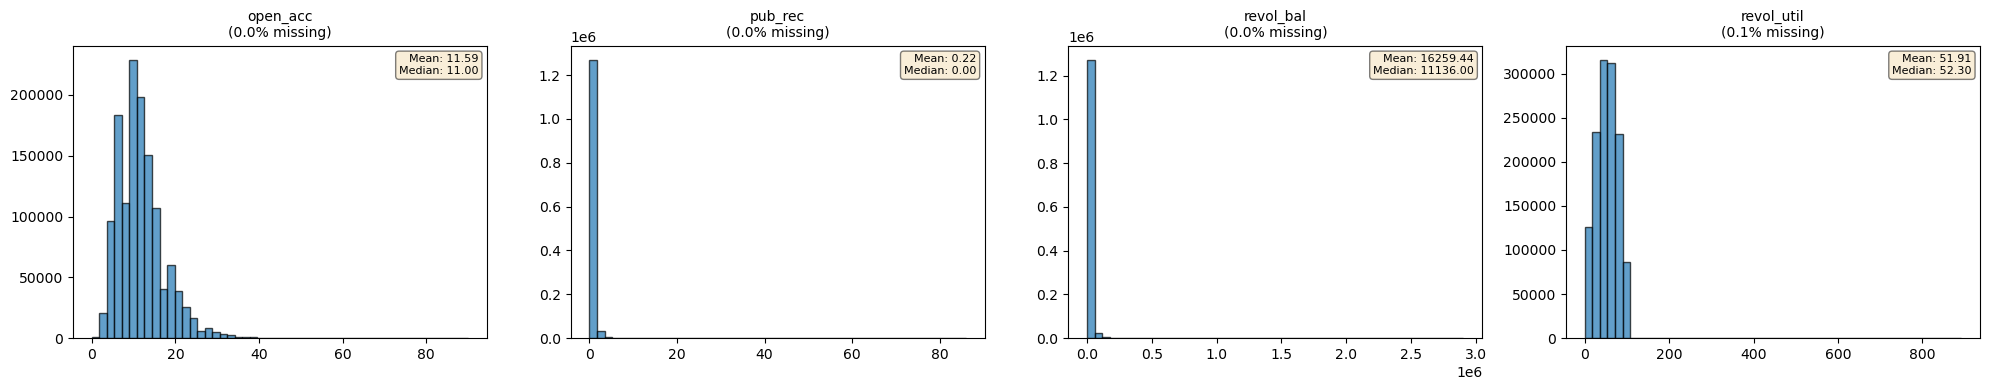

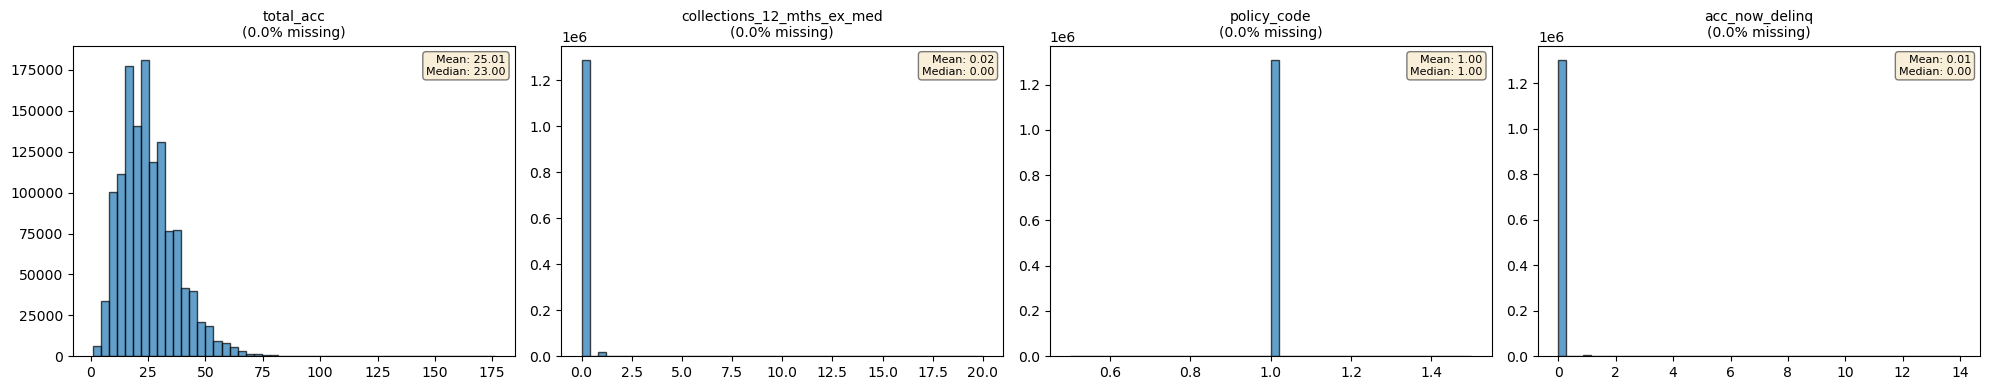

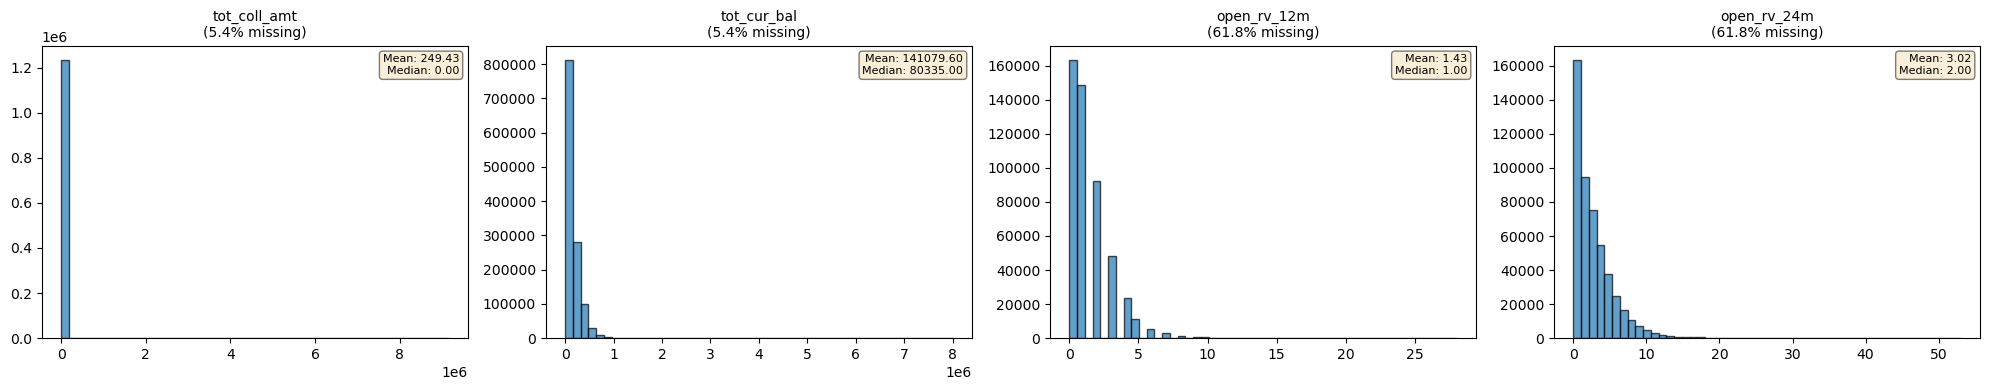

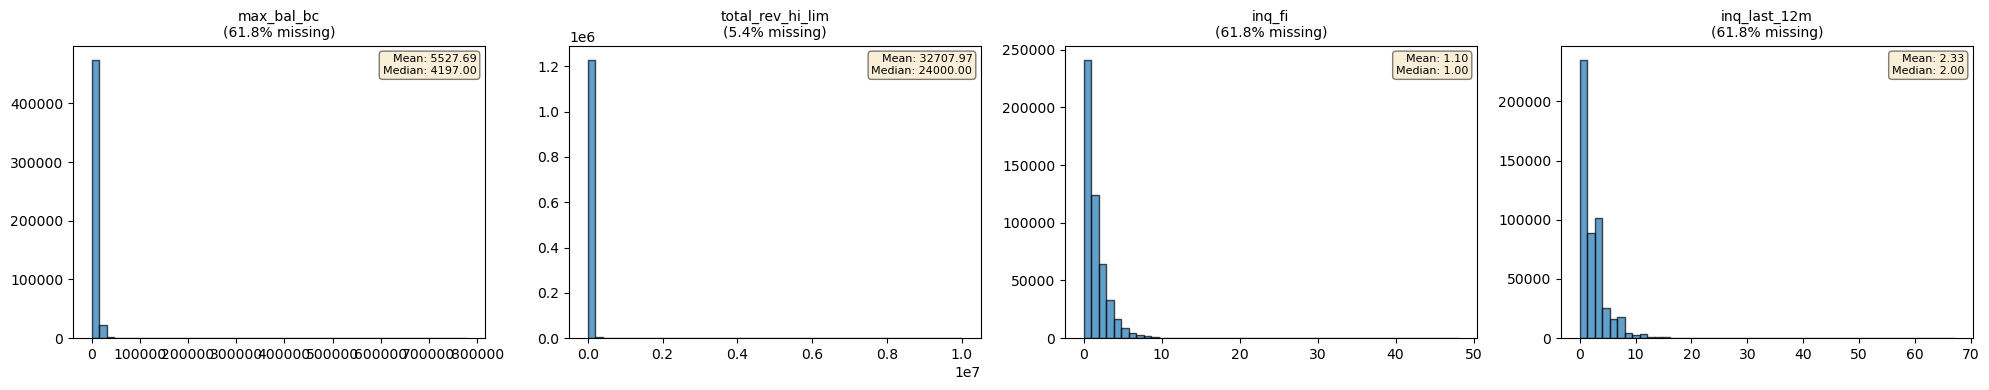

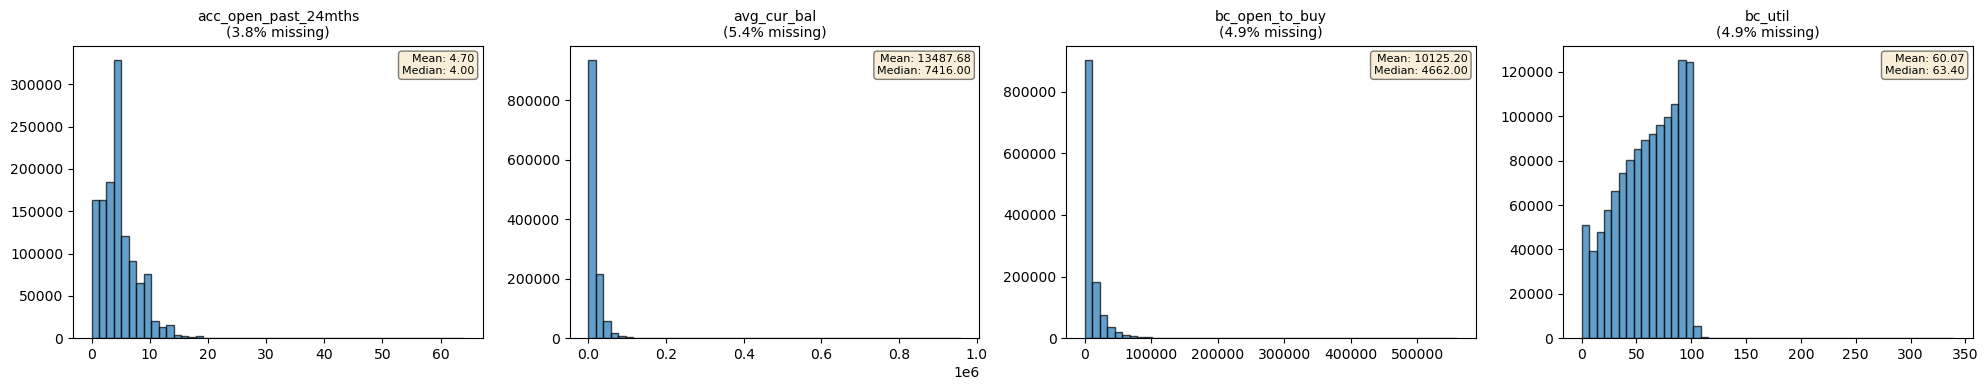

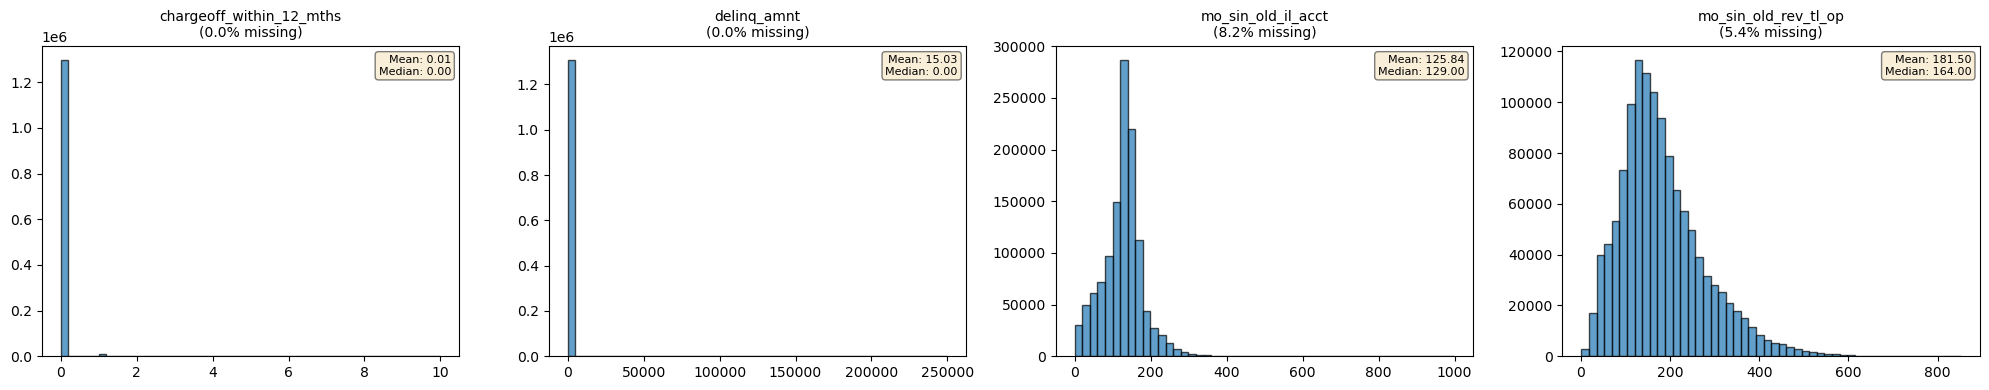

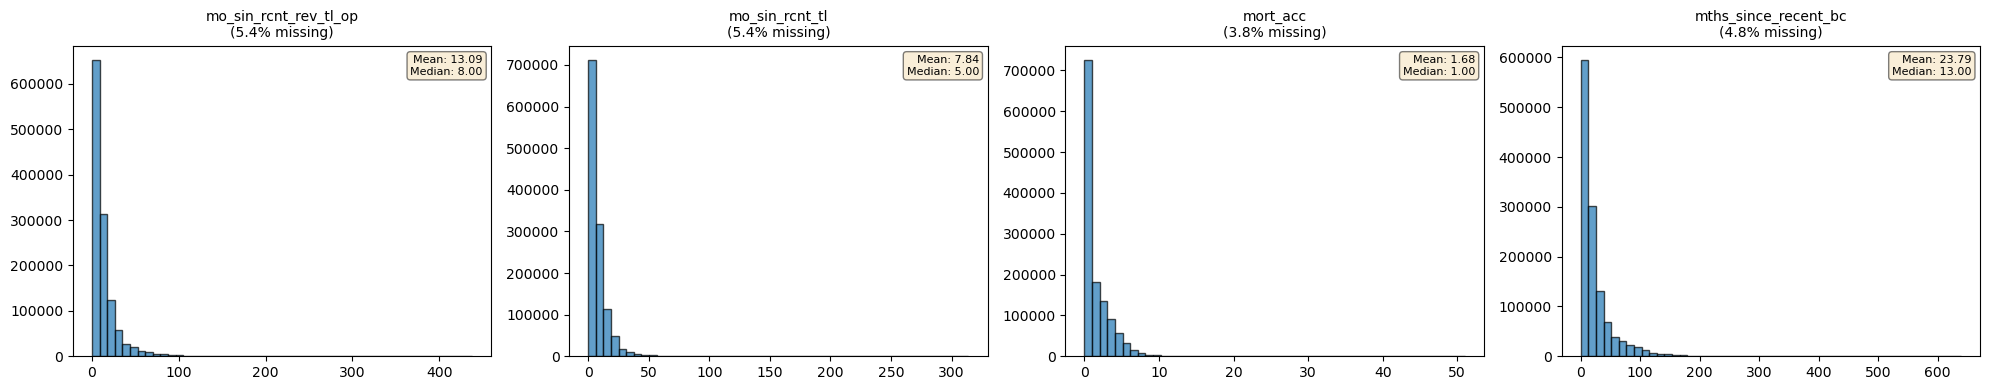

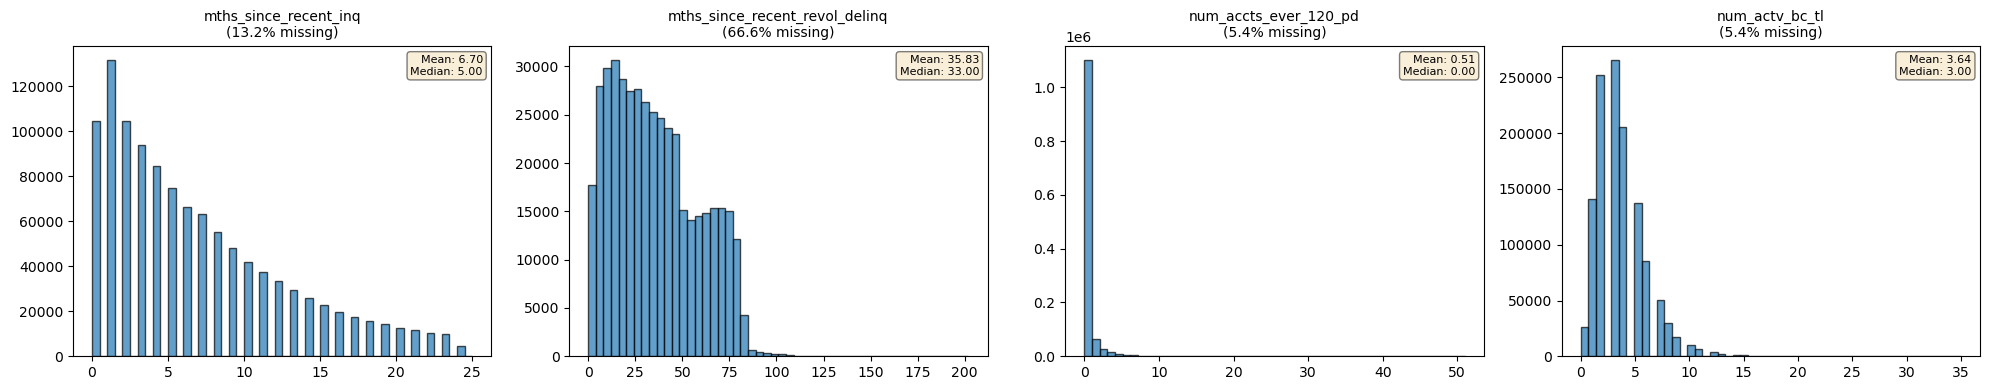

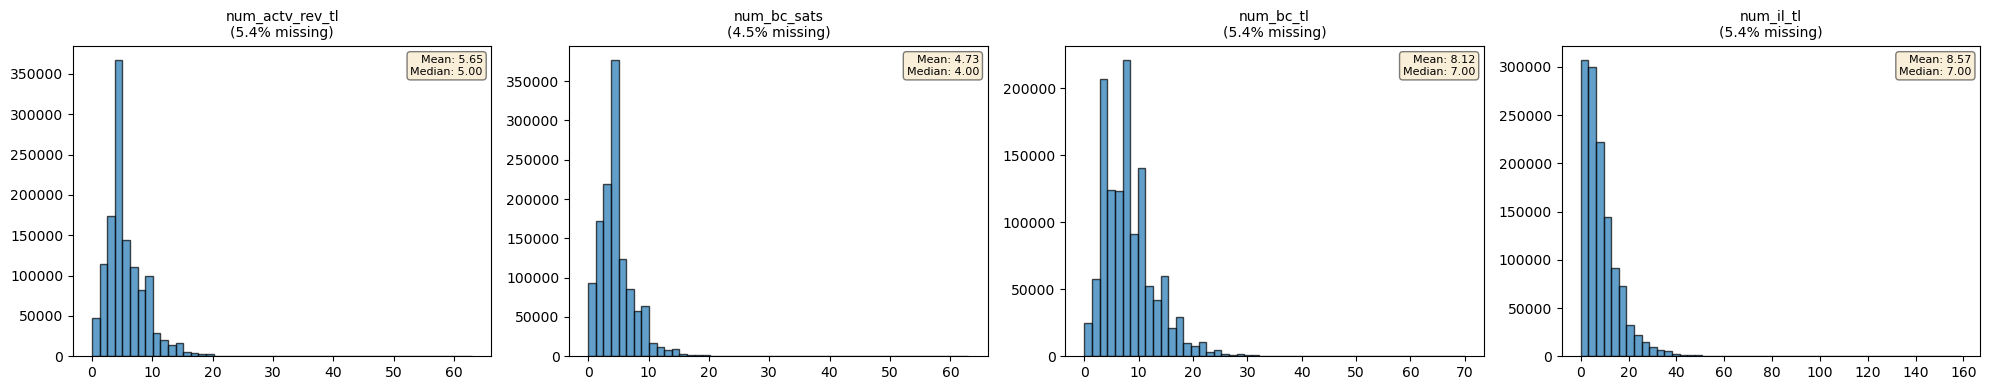

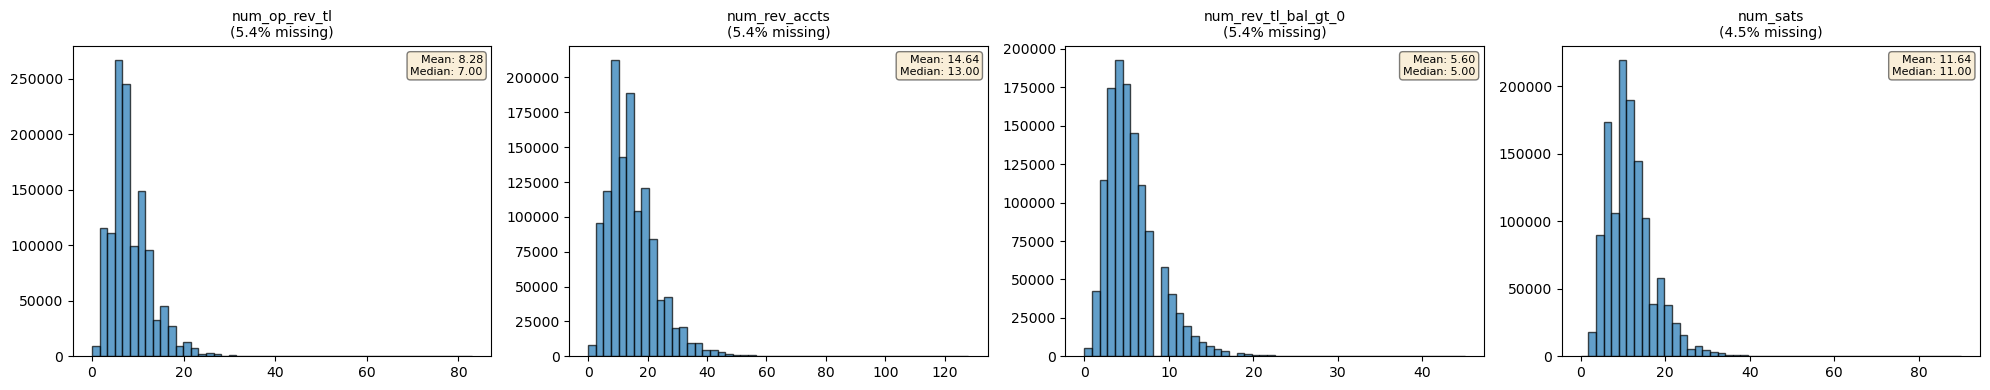

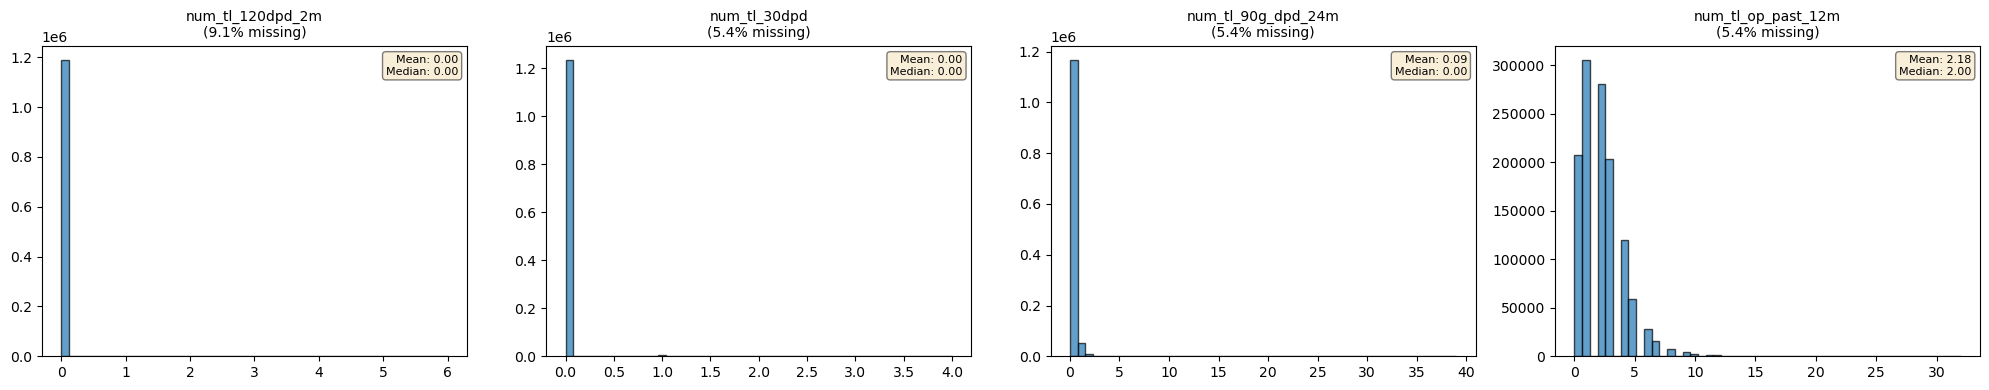

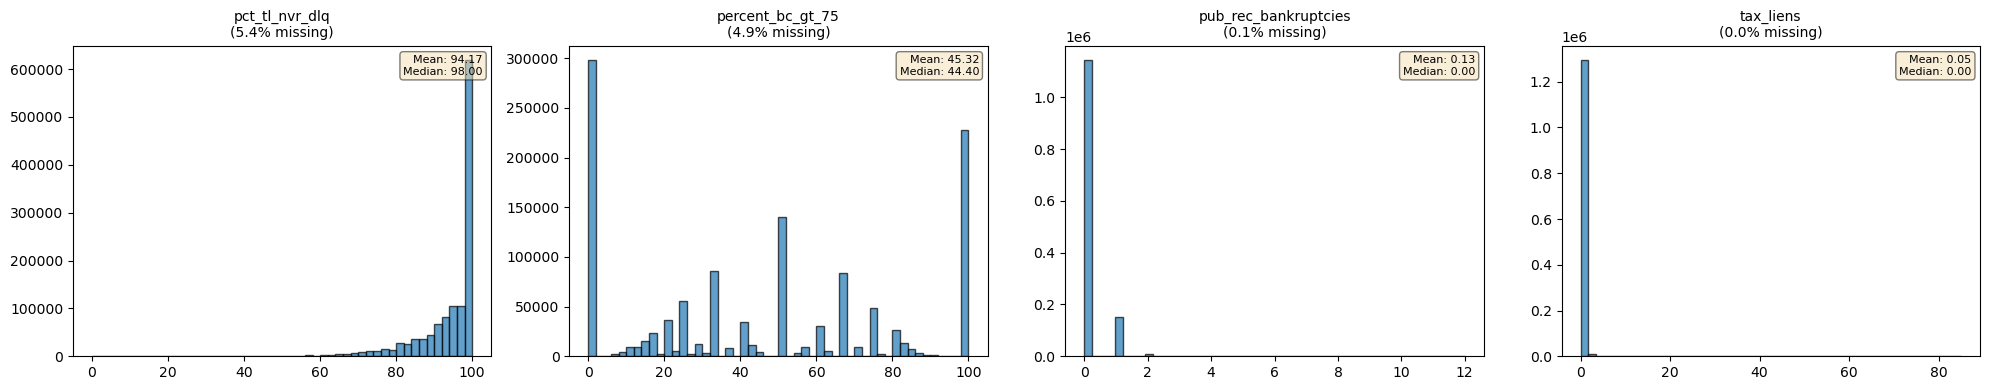

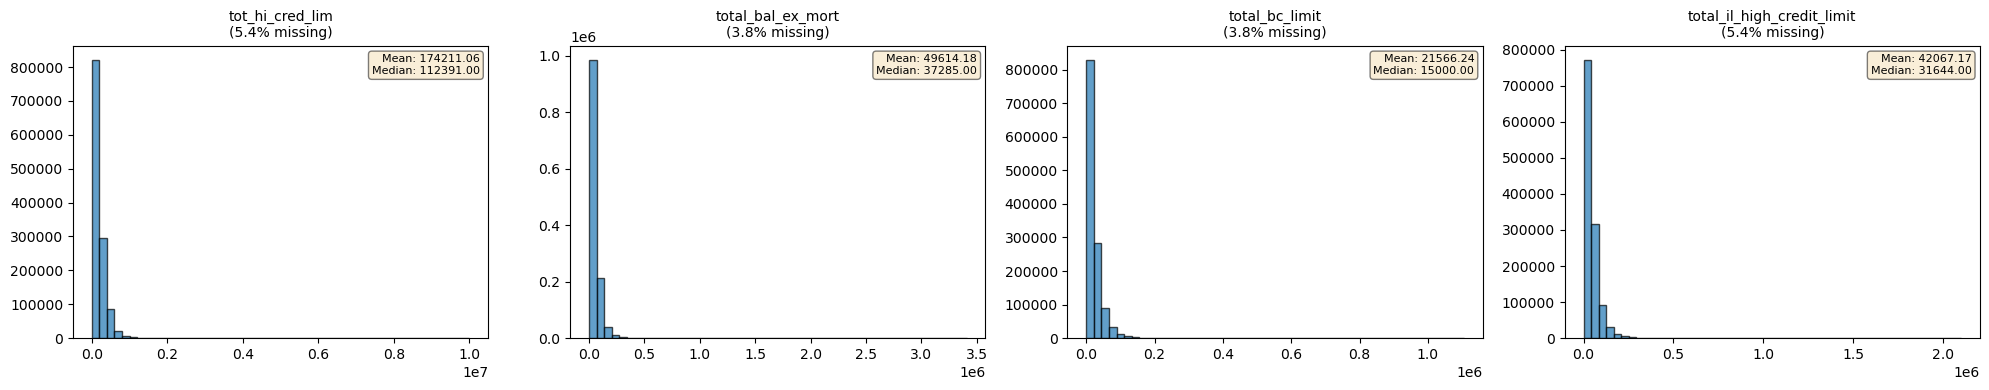

missing numerical features






In [13]:
#### Step 8: Imputation Strategy for continuous variables ####
print("Step 8")
def plot_numerical_features(df, categorical_cols_list, target_col='loan_status_binary'):
    import matplotlib.pyplot as plt

    numerical_cols = [col for col in df.columns
                     if col not in categorical_cols_list and col != target_col
                     and df[col].dtype in ['int64', 'float64', 'Int64', 'Float64']]

    n_cols = 4
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    for row in range(n_rows):
        fig, axes = plt.subplots(1, n_cols, figsize=(20, 4))
        if n_cols == 1:
            axes = [axes]

        for i in range(n_cols):
            idx = row * n_cols + i
            ax = axes[i]

            if idx < len(numerical_cols):
                col = numerical_cols[idx]
                data = df[col].dropna()
                missing_pct = (df[col].isnull().sum() / len(df)) * 100

                if len(data) > 0:
                    ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
                    ax.set_title(f'{col}\n({missing_pct:.1f}% missing)', fontsize=10)
                    stats = f'Mean: {data.mean():.2f}\nMedian: {data.median():.2f}'
                    ax.text(0.98, 0.97, stats, transform=ax.transAxes, va='top', ha='right',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=8)
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.show()

    return numerical_cols


# check if I did not mess up my code
print(categorical_cols_final == ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                       'verification_status', 'purpose', 'application_type'])

categorical_features = ['issue_d', 'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                       'verification_status', 'purpose', 'zip_code', 'addr_state',
                       'earliest_cr_line', 'application_type']

numerical_features = plot_numerical_features(df_no_leakage, categorical_features)


"""
here are the imputations strategies we will use based on the visualizations:
"""
"""
Note: No mean imputation because nearly all data is skewed 
-> median imputation except for certain cases

revol_util cf imaege looks normally distributed so mean imputation could be used there too
"""

# Imputation strategy for missing values

# Fill with 0 - Missing means "never happened" or "none"
fill_with_zero = [
    'delinq_2yrs','open_rv_12m', 'open_rv_24m', 'inq_fi', 'inq_last_12m',
    'num_accts_ever_120_pd', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
    'num_tl_90g_dpd_24m', 'chargeoff_within_12_mths', 'delinq_amnt',
    'tot_coll_amt', 'pub_rec_bankruptcies',
    'collections_12_mths_ex_med',  # Number of collections
    'acc_now_delinq',               # Number of currently delinquent accounts
    'tax_liens',                    # Number of tax liens
    'inq_last_6mths',              # Number of inquiries
    'pub_rec',                      # Number of public records
]

for col in fill_with_zero:
    if col in df_no_leakage.columns:
        df_no_leakage[col] = df_no_leakage[col].fillna(0)

# Fill with 999 - Missing means "event never occurred"
fill_with_999 = [
    'mths_since_recent_revol_delinq',
    'mths_since_last_record',
    'mths_since_recent_bc',
    'mths_since_recent_inq'
]

for col in fill_with_999:
    if col in df_no_leakage.columns:
        df_no_leakage[col] = df_no_leakage[col].fillna(999)

# Fill with median - Continuous amounts, percentages, and counts
fill_with_median = fill_with_median = [
    # Balances and amounts
    'annual_inc','tot_cur_bal', 'avg_cur_bal', 'bc_open_to_buy', 'max_bal_bc',
    'total_rev_hi_lim', 'tot_hi_cred_lim', 'total_bal_ex_mort',
    'total_bc_limit', 'total_il_high_credit_limit',
    # Percentages/ratios
    'bc_util', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
    # Account counts
    'mort_acc', 'acc_open_past_24mths', 'num_actv_bc_tl', 
    'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
    'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
    'num_sats', 'num_tl_op_past_12m',
    # Time features (months)
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'revol_util',
    'dti',         # Debt-to-income ratio
    'open_acc',    # Number of open credit lines (median safer than 0)
    'total_acc',   # Total number of credit lines (median safer than 0)
    ]


from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
median_cols_present = [col for col in fill_with_median if col in df_no_leakage.columns]
df_no_leakage[median_cols_present] = imputer.fit_transform(df_no_leakage[median_cols_present])


categorical_features = ['issue_d', 'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                       'verification_status', 'purpose', 'zip_code', 'addr_state',
                       'earliest_cr_line', 'application_type']


print("missing numerical features")
missing_pct3 = (df_no_leakage.isnull().sum() / len(df_no_leakage)) * 100
for col, pct in missing_pct3.items():
    if abs(pct) > 1e-12 and col not in categorical_features:
        print(f"  - {col}: {pct}% missing")

print("\n\n\n")





step 9
missing categorical features
  - emp_length: 5.77860924825492% missing
  - zip_code: 7.654699564524142e-05% missing
  - earliest_cr_line: 0.002219862873712001% missing


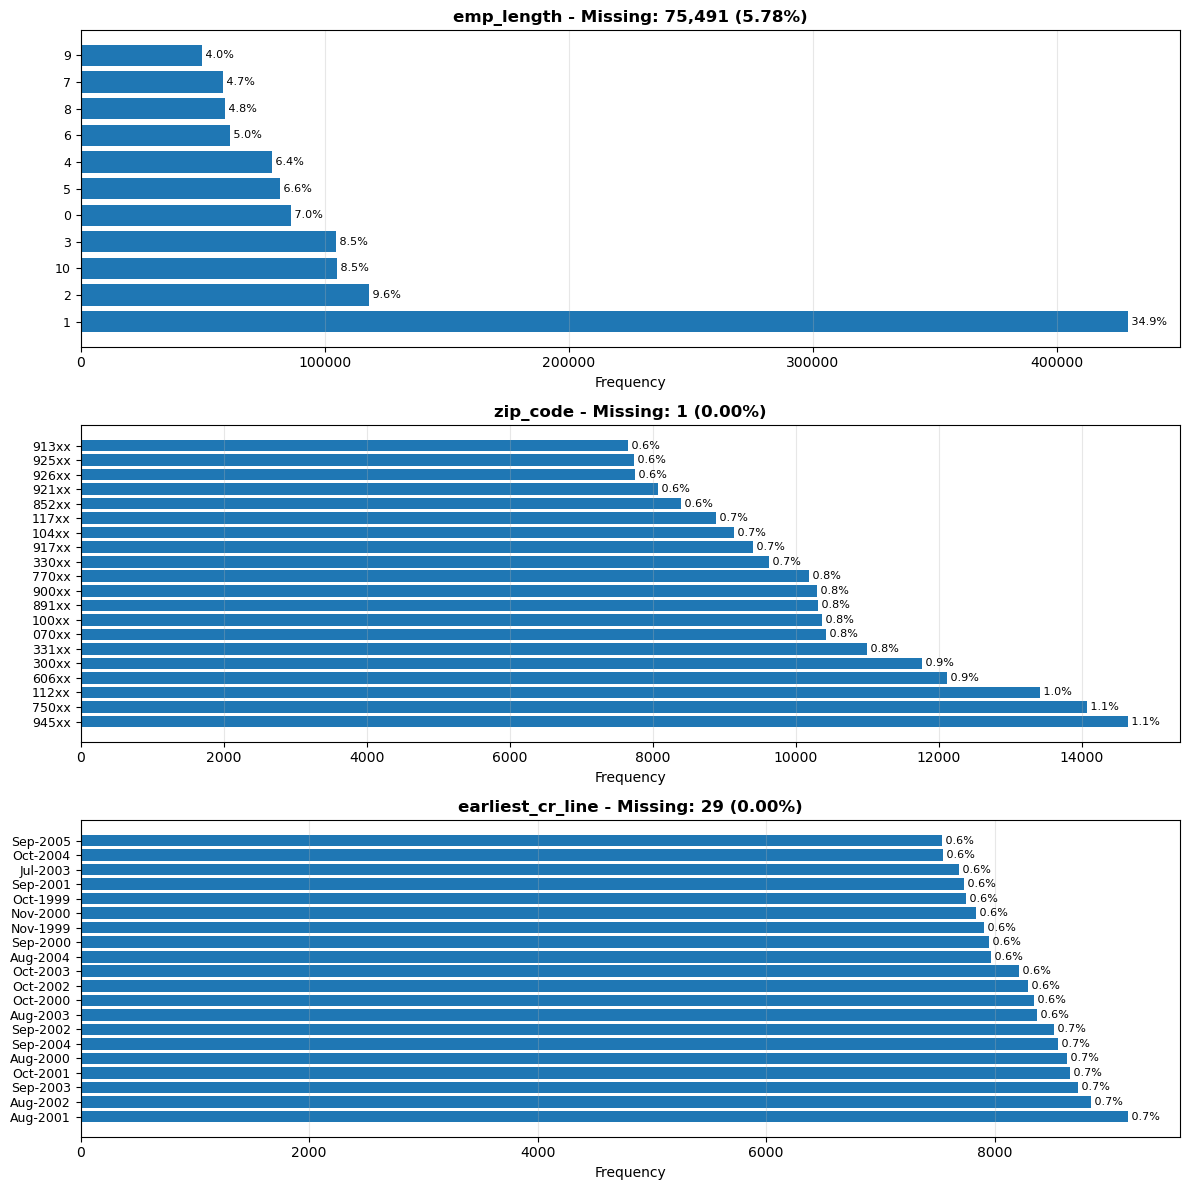

In [14]:
### step 9: Imputation for categorical variables ###
print("step 9")
"""
Choosing a Method

Mode imputation: Simple, works well when one category dominates
"Missing" category: Best when missingness itself is informative
Forward/backward fill: For ordered/temporal data
Predictive: When you have strong correlations with other features

Important: The method depends on:

Why data is missing (random vs. systematic)
The distribution of your categories
Whether missingness carries information
Your downstream task
"""

categorical_features = ['issue_d', 'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                       'verification_status', 'purpose', 'zip_code', 'addr_state',
                       'earliest_cr_line', 'application_type']


missing_pct4 = (df_no_leakage.isnull().sum() / len(df_no_leakage)) * 100
print("missing categorical features")
for col, pct in missing_pct3.items():
    if abs(pct) > 1e-12 and col in categorical_features:
        print(f"  - {col}: {pct}% missing")



import matplotlib.pyplot as plt

def plot_categorical_missing(df, var_list):
    """Quick visualization of categorical variables with missing values"""
    fig, axes = plt.subplots(len(var_list), 1, figsize=(12, 4*len(var_list)))
    if len(var_list) == 1:
        axes = [axes]
    
    for idx, var in enumerate(var_list):
        data = df[var].dropna()
        value_counts = data.value_counts().head(20)  # Top 20
        
        axes[idx].barh(range(len(value_counts)), value_counts.values)
        axes[idx].set_yticks(range(len(value_counts)))
        axes[idx].set_yticklabels(value_counts.index, fontsize=9)
        axes[idx].set_xlabel('Frequency')
        axes[idx].set_title(f'{var} - Missing: {df[var].isnull().sum():,} ({df[var].isnull().sum()/len(df)*100:.2f}%)', 
                           fontsize=12, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Add percentage labels
        for i, v in enumerate(value_counts.values):
            pct = v / len(data) * 100
            axes[idx].text(v, i, f' {pct:.1f}%', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()


plot_categorical_missing(df_no_leakage, ['emp_length', 'zip_code', 'earliest_cr_line'])


"""
We sill assign an unknown category here for missing because missingness 
in employment length is likely informative
could indicate unemployment, self-employment, or reluctance to disclose, 
which are all predictive for credit risk.
"""
df_no_leakage['emp_length'] = df_no_leakage['emp_length'].fillna(-1)
# zip_code: Mode imputation (only 1 missing)
df_no_leakage['zip_code'] = df_no_leakage['zip_code'].fillna(
    df_no_leakage['zip_code'].mode()[0]
)
# earliest_cr_line: Mode or median (only 29 missing)
df_no_leakage['earliest_cr_line'] = df_no_leakage['earliest_cr_line'].fillna(
    df_no_leakage['earliest_cr_line'].mode()[0]
)




In [15]:
"""
Checking at last how many missing values are left
"""
print("Total missing values")
print(df_no_leakage.isnull().sum().sum())

print(list(df_no_leakage.columns))
"""
AT LASSSTTT
"""

df = df_no_leakage.copy()
df.to_csv("C:\\ESILV A4\\ESILV A4 DIA\\Machine Learning\\Projet ML\\cleaned_lending_club_data.csv", index=False)


Total missing values
0
['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim', 'inq_fi', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num